### Overview

Twitter users generate millions of tweets everyday, and much of this is aimed at a particular product or brand. Companies need to find quick and effective ways to sort through the millions of tweets and identify those that indicate unhappy consumers so that they can quickly respond before the negative experience is amplified across media and the company risks losing customers. It is also important that companies are able to correctly identify positive brand sentiment so that those tweets can be amplified across social media.

### Aim:
To classify a tweet as having positive or negative sentiment.

A set of actual tweets will be vectorized with the help of Natural Language Processing. Then modeling techniques will be used to classify them as either positive or negative.

### Data:
The dataset used in this project can be found [here](https://data.world/crowdflower/brands-and-product-emotions) In this dataset, contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.

### EDA

First, data is analyzed to ascertain cleaning requirements and to visualize the target distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

reading the csv file using pandas

In [2]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv',
                 encoding='unicode_escape',
                 header=0,
                 names=['tweet_text', 'brand', 'emotion'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   brand       3291 non-null   object
 2   emotion     9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


1 tweet_text has a NaN value and majority of brand entries are missing...

In [4]:
df = df.dropna(subset=['tweet_text'])

In [5]:
print(df.shape)
df.head(3)

(9092, 3)


,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


Let's Explore the data and identify the unique entries for product(`brand`) and sentiments(`emotion`).

In [6]:
df.brand.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [7]:
df.emotion.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [8]:
apple_list = ['iPhone', 'iPad or iPhone App','iPad','Apple','Other Apple product or service']
google_list = ['Google', 'Android', 'Android App', 'Other Google product or service']

def brand_name(row):
    if row in apple_list:
        return 'Apple'
    elif row in google_list:
        return 'Google'
    else:
        return np.nan

Mapping apple products to Apple and android/google products to Google

In [9]:
df.loc[:, 'brand'] = df.brand.map(brand_name)

In [10]:
df.brand.value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [11]:
df.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [12]:
def emotion_name(row):
    if row == 'Positive emotion':
        return 'Positive'
    elif row == 'Negative emotion':
        return 'Negative'
    else:
        return 'Neutral_or_unknown'

In [13]:
df.emotion = df.emotion.map(emotion_name)

In [14]:
df.emotion.value_counts(sort=False)

Positive              2978
Neutral_or_unknown    5544
Negative               570
Name: emotion, dtype: int64

our data has a large class imbalance both in the target variable and in the product the tweet is directed towards. We also have a large number of retweets, which are essentially duplicates. For our purposes, we are going to drop the retweets.

Let's visualize how the target is distributed with respect to the brands in our dataset

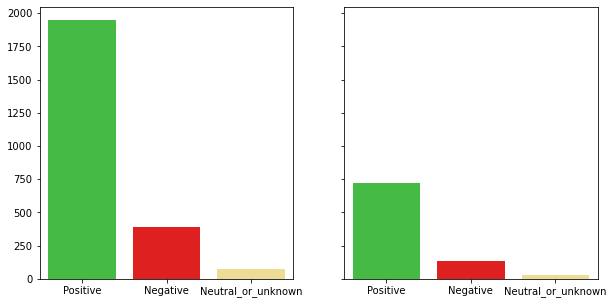

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
for idx, brand in enumerate(['Apple', 'Google']):
    plot_data = df[df['brand'] == brand].emotion.value_counts()
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax[idx], palette=['limegreen', 'red', '#FDE587'])
plt.show();

visualizing data for missing brand information

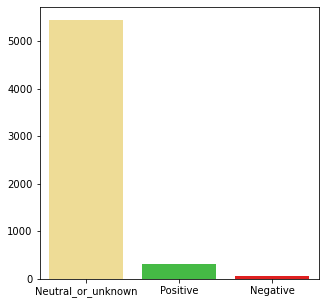

In [16]:
plt.figure(figsize=(5,5))
plot_data = df[df['brand'].isna()].emotion.value_counts()
sns.barplot(x=plot_data.index, y=plot_data.values, palette=['#FDE587', 'limegreen', 'red']); 

In [17]:
df.head(10)

,tweet_text,brand,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral_or_unknown
7,"#SXSW is just starting, #CTIA is around the co...",Google,Positive
8,Beautifully smart and simple idea RT @madebyma...,Apple,Positive
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
10,Excited to meet the @samsungmobileus at #sxsw ...,Google,Positive


In [18]:
pd.set_option('max_colwidth', 400)

In [19]:
df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))].head()

,tweet_text,brand,emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},NaN,Positive
64,Again? RT @mention Line at the Apple store is insane.. #sxsw,NaN,Negative
68,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",NaN,Negative
103,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw,NaN,Negative
112,Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link},NaN,Positive


357 entries that have missing brand values exhibit either a positive or negative emotion. From the tweet_text we can ascertain the brand being discussed about. If the text has either Apple, iPhone or iPad we'll assume the brand being discussed is Apple and if the text has either android or Google we can assume the brand to be Google

In [20]:
# missing_brand = df[(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))]

# def brand_name_for_missing_brands(row):
#     from re import search
#     if search(r'Apple|iPad|iPhone', row['tweet_text']):
#         return 'Apple'
#     elif search(r'android|Google', row['tweet_text']):
#         return 'Google'
#     else:
#         return np.nan

# missing_brand['brand'] = missing_brand.apply(brand_name_for_missing_brands, axis=1)

# missing_brand

# df1 = df[~(df.brand.isna()) & (df.emotion.isin(['Positive', 'Negative']))]

# df = pd.concat([df1, missing_brand], axis=0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   brand       3291 non-null   object
 2   emotion     9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


Retweets in the dataset are tagged with characters 'RT' in the tweet_text. Let's remove tweet containing 'RT' pattern using `re`

In [22]:
from re import search
def not_a_retweet(row):
    if not search(r'RT', row):
        return True
    else:
        return False       

In [23]:
df = df[df.tweet_text.map(not_a_retweet)].loc[:,['tweet_text', 'emotion', 'brand']]

In [24]:
df.shape

(6415, 3)

In [25]:
df.head()

,tweet_text,emotion,brand
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative,Apple
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive,Google


In [26]:
corpus = df.loc[:, ['tweet_text', 'emotion']] 

In [27]:
corpus.head()

,tweet_text,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive


### Preprocessing

In [28]:
X = corpus['tweet_text']
y= corpus['emotion']
print(len(X))
print(len(y))
len(X) == len(y)

6415
6415


True

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
from nltk.corpus import stopwords, wordnet
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
from nltk.tokenize import word_tokenize, regexp_tokenize, RegexpTokenizer

In [33]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [35]:
# import nltk
# nltk.download('punkt')

In [36]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [37]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [38]:
token_docs[0]

'ipad acquire thanks mention perserverance vote husband year check sxsw'

In [39]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=1)

Let's also use the **FreqDist** tool to look at the makeup of our text after removal of common stopwords

In [40]:
word_list = []
for text in X_t:
    words = word_tokenize(text)
    for word in words:
        word_list.append(word)

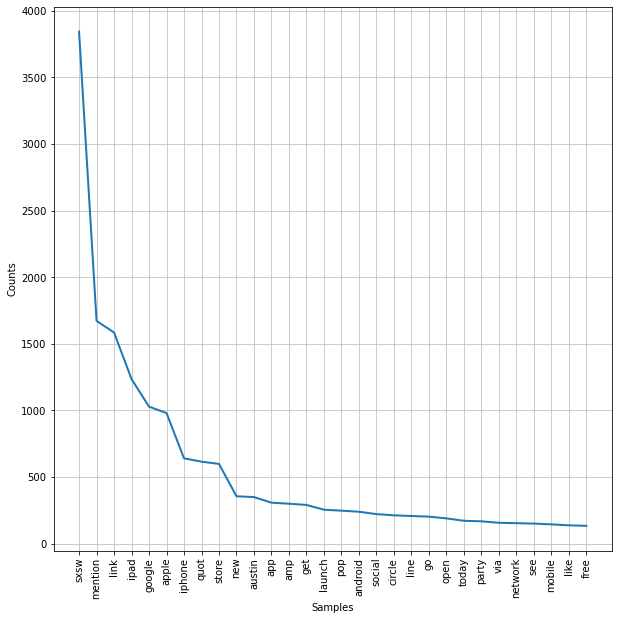

In [41]:
from nltk.probability import FreqDist
fdist = FreqDist(word_list)
plt.figure(figsize=(10,10))
fdist.plot(30);

potential to remove a few more stopwords: sxsw (the festival in which these tweet were made), mention, link, ipad, google, apple, iphone, austin (place where teh festival was held)

In [42]:
sw.extend(['sxsw', 'mention', 'link', 'ipad', 'google', 'apple', 'iphone', 'austin', 'quot', 'store', 'android', 'new'])

In [43]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [44]:
token_docs[0]

'acquire thanks perserverance vote husband year check'

In [45]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=1)

In [46]:
word_list = []
for text in X_t:
    words = word_tokenize(text)
    for word in words:
        word_list.append(word)

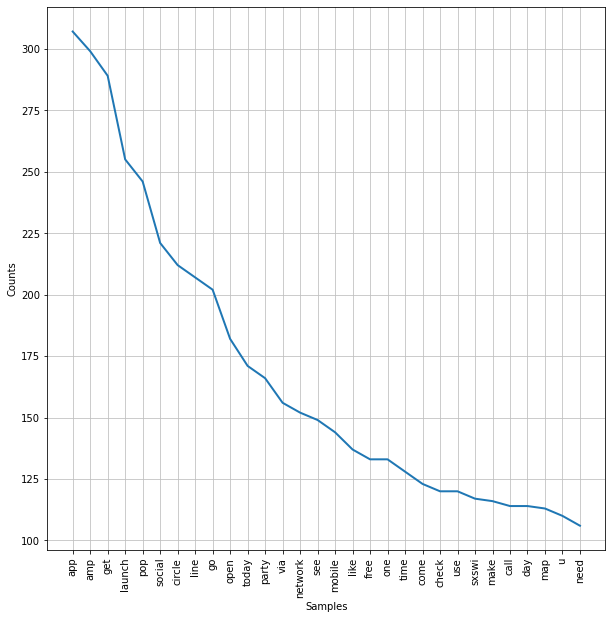

In [47]:
fdist = FreqDist(word_list)
plt.figure(figsize=(10,10))
fdist.plot(30);

In [48]:
from wordcloud import WordCloud

In [87]:
my_string = ''
for i in token_docs:
    my_string += str(' ') + i

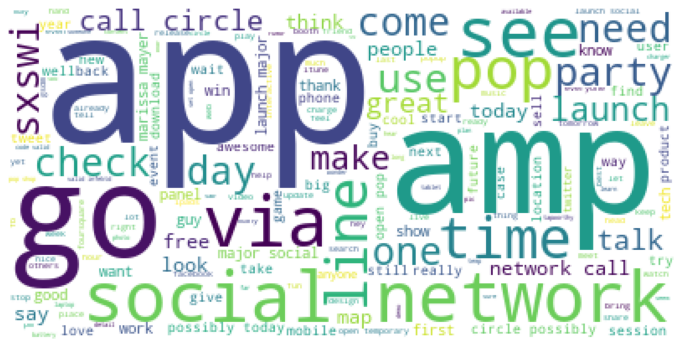

In [88]:
words_cloud = WordCloud(background_color='white').generate(my_string)
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(words_cloud)
plt.show()

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
tfidfv = TfidfVectorizer()
X_t_vec = tfidfv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = tfidfv.get_feature_names()
X_t_vec.set_index(y_t.index, inplace=True)

In [63]:
X_t_vec.head()

,aapl,aaron,ab,abacus,abba,abc,aber,ability,able,abnormal,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
9084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
X_val_vec = tfidfv.transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = tfidfv.get_feature_names()
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec.head()

,aapl,aaron,ab,abacus,abba,abc,aber,ability,able,abnormal,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modeling
Multinomial Naive Bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [65]:
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [73]:
confusion_matrix(y_t, mnb.predict(X_t_vec))

array([[   4,  238,   23],
       [   0, 2174,    7],
       [   0,  668,  494]])

In [70]:
y_t.value_counts()

Neutral_or_unknown    2181
Positive              1162
Negative               265
Name: emotion, dtype: int64

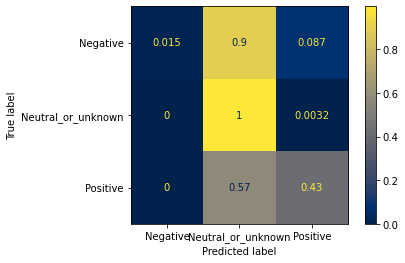

In [76]:
plot_confusion_matrix(mnb, X_t_vec, y_t, cmap='cividis', normalize='true');

model is predicting Neutral/unknown for most of the tweets. This could be due to the class imbalance in the dataset. For now Let's try and limit the classes to only positve or negative and learn from those tweets alone.

Back to data cleaning....

In [82]:
corpus2 = corpus[~(corpus['emotion']== 'Neutral_or_unknown')]

In [83]:
corpus2.head()

,tweet_text,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive


In [84]:
corpus2.shape

(2575, 2)

In [86]:
corpus2.to_csv('../../data/corpus2.csv', index=False)